In [77]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from skimage.io import imshow
from skimage.data import imread
from skimage.segmentation import find_boundaries
from skimage.segmentation import mark_boundaries
from skimage.filters import gaussian
from skimage.util import montage
from keras.preprocessing.image import save_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array

from utils import rle_encode
from utils import rle_decode
from utils import quick_stats

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
train_image_dir = os.path.join(ship_dir, 'train')
train = os.listdir(train_image_dir)
test_image_dir = os.path.join(ship_dir, 'test')
test = os.listdir(test_image_dir)

['corruptedtestimages.csv', 'corruptedtrainimages.csv', 'train_ship_segmentations.csv', 'train', 'test', 'sample_submission.csv']
104070
88500


In [2]:
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations.csv'))
masks = masks.dropna()
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

56030 masks found
29070


,ImageId,EncodedPixels
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...
5,00021ddc3.jpg,150423 2 151190 3 151958 3 152726 4 153495 3 1...


In [3]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.1, stratify = unique_img_ids['counts'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

50428 training masks
5602 validation masks


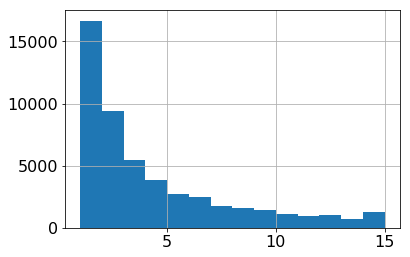

In [4]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
train_df['counts'].hist(bins=train_df['counts'].max());

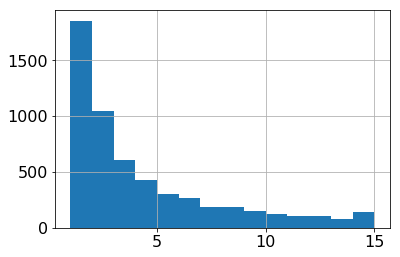

In [5]:
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
valid_df['counts'].hist(bins=valid_df['counts'].max());

In [6]:
train_df = train_df[train_df['counts'] >= 12]
valid_df = valid_df[valid_df['counts'] >= 12]
train_df.shape[0]

2984

In [7]:
train_df.groupby(['counts']).size()

counts
12    1008
13     689
14     672
15     615
dtype: int64

In [8]:
def make_image_gen(in_df, batch_size=16):
    all_batches = list(in_df.groupby('ImageId'))
    cnt = 0
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            out_rgb += [imread(rgb_path)]
            out_mask += [masks_as_image(c_masks['EncodedPixels'].values)]
            print(cnt+1, c_img_id, c_masks['counts'].values)
            cnt += 1
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                cnt, out_rgb, out_mask = 0, [], []

In [10]:
BATCH_SIZE = 16

In [11]:
train_gen = make_image_gen(train_df, batch_size=BATCH_SIZE)
valid_gen = make_image_gen(valid_df, batch_size=BATCH_SIZE)

In [12]:
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max(), train_x[0, 0, 0])
print('y', train_y.shape, train_y.min(), train_y.max(), train_y[0, 0, 0])

1 02766c52b.jpg [13 13 13 13 13 13 13 13 13 13 13 13 13]
2 8c507ced4.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
3 3f33be256.jpg [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
4 22f3eb045.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
5 59195b205.jpg [14 14 14 14 14 14 14 14 14 14 14 14 14 14]
6 60ca4f877.jpg [13 13 13 13 13 13 13 13 13 13 13 13 13]
7 42bee6533.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
8 02776139a.jpg [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
9 8157ad66f.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
10 3b5086f4e.jpg [14 14 14 14 14 14 14 14 14 14 14 14 14 14]
11 b4f2fa5da.jpg [13 13 13 13 13 13 13 13 13 13 13 13 13]
12 a0c26d000.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
13 e21063b79.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
14 f9f6f5005.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
15 754326edc.jpg [14 14 14 14 14 14 14 14 14 14 14 14 14 14]
16 e36fb2bf9.jpg [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]
x (16, 768, 768, 3) 0.0 1.0 [0.20784314 0.46666667 0.42745098]
y (16, 768, 

Text(0.5,1,'Outlined Ships')

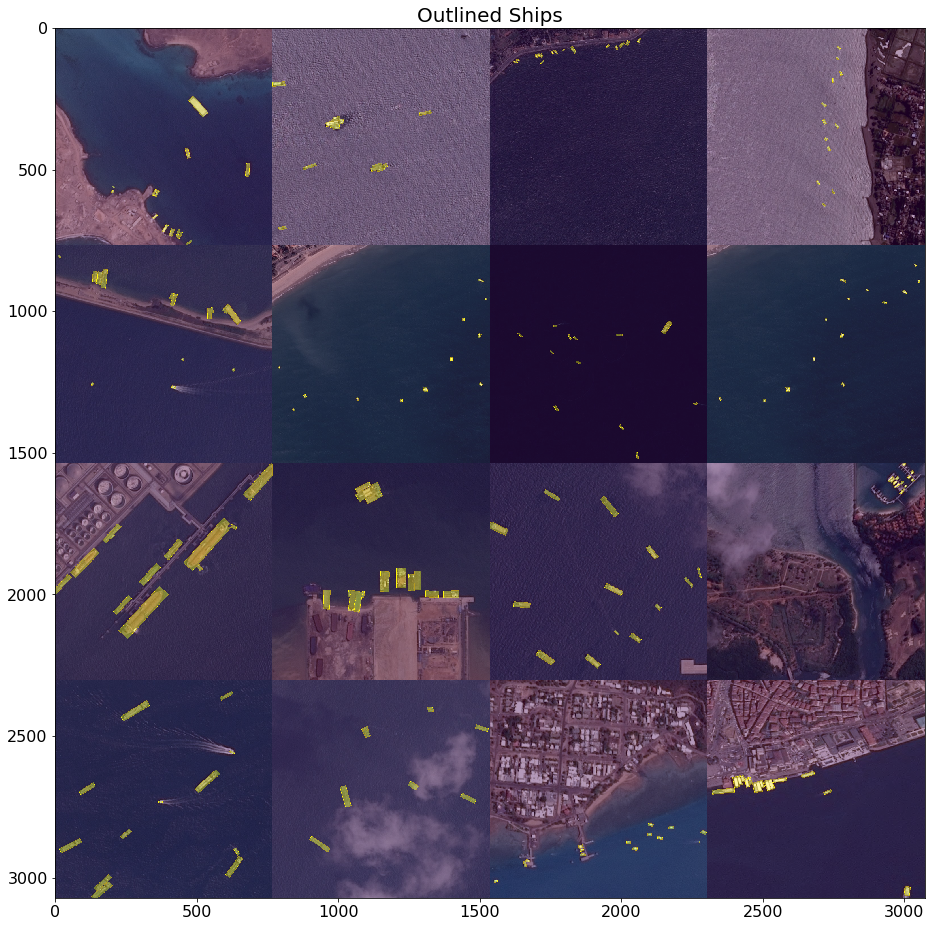

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax.imshow(batch_seg, alpha=0.4)
ax.set_title('Outlined Ships')

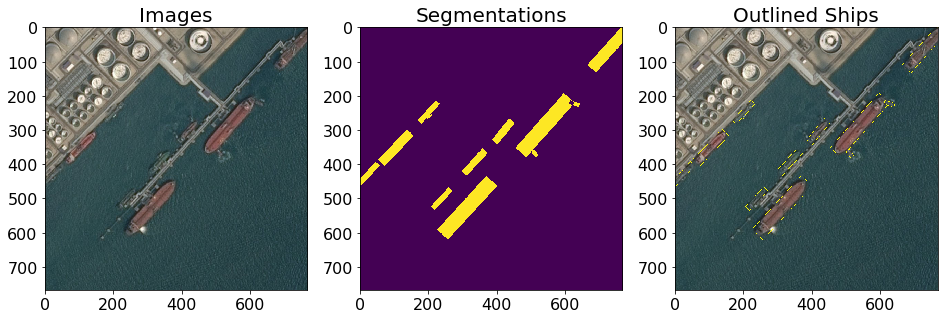

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 10))
batch_rgb = train_x[8]
batch_seg = train_y[8, :, :, 0]
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(all_masks, alpha=0.4)
ax3.imshow(find_boundaries(batch_rgb, batch_seg.astype(int), mode='thick'))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

In [56]:
from utils import rle_to_label_mask
from utils import read_stacked_masks
from utils import read_flat_mask

In [164]:
ImageId = '929e28f93.jpg'
# ImageId = '8157ad66f.jpg'

img = imread(os.path.join(train_image_dir, ImageId))
in_mask_list = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

merged_masks = rle_to_label_mask(in_mask_list)

bnd = find_boundaries(merged_masks, mode='outer') * 1.0
print(bnd.shape, np.max(bnd))
wht = gaussian(bnd, sigma=2)

img = imread(os.path.join(train_image_dir, ImageId))

all_masks = read_flat_mask(ImageId, masks)

bnd_in = find_boundaries(merged_masks, mode='inner')
bnd_out = find_boundaries(merged_masks, mode='outer')
bnd_thick = find_boundaries(merged_masks, mode='thick')

msk = all_masks > 0.5
msk_in = msk ^ bnd_in
msk_in2 = msk & ~bnd_thick
wht_in = gaussian(bnd_in, sigma=2)
wht_out = gaussian(bnd_out, sigma=2)
wht_thick = gaussian(bnd_thick, sigma=2)
wht_inout = wht_out + wht_in

In [165]:
quick_stats(stacked_masks)
quick_stats(merged_masks)
quick_stats(all_masks)
quick_stats(msk)
quick_stats(msk_in)
quick_stats(msk_in2)
print('-' * 60)
quick_stats(bnd_in)
quick_stats(bnd_out)
quick_stats(bnd_thick)
print('-' * 60)
quick_stats(wht_in)
quick_stats(wht_out)
quick_stats(wht_thick)
quick_stats(wht_inout)

(13, 768, 768) uint8 1 0 0.0008012820512820513 0.028295582665079484 6144
(768, 768) uint8 13 0 0.08836534288194445 0.9325193200803887 52120
(768, 768) uint64 1 0 0.010416666666666666 0.10152910775842669 6144
(768, 768) bool True False 0.010416666666666666 0.10152910775842669 6144
(768, 768) bool True False 0.008807712131076388 0.09343519860359094 5195
(768, 768) bool True False 0.008807712131076388 0.09343519860359094 5195
------------------------------------------------------------
(768, 768) bool True False 0.0016089545355902778 0.04007949352091017 949
(768, 768) bool True False 0.0016716851128472222 0.040852057252122646 986
(768, 768) bool True False 0.0030364990234375 0.05502071152864313 1791
------------------------------------------------------------
(768, 768) float64 0.4134296263504809 0.0 0.001608954535590278 0.01678437905362567 949.0000000000001
(768, 768) float64 0.4141469760536347 0.0 0.0016716851128472227 0.017265717063994792 986.0000000000002
(768, 768) float64 0.69677352

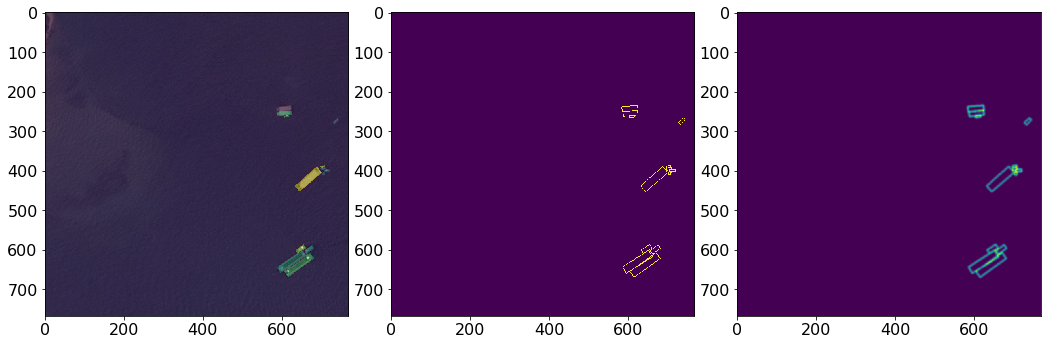

In [142]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].imshow(img)
axarr[0].imshow(merged_masks, alpha=0.4)
axarr[1].imshow(bnd_thick)
axarr[2].imshow(wht_thick)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [ ]:
print(msk_in[618:622,658:662]*1.0)
print(bnd[618:622,658:662]*0.5)

In [73]:
save_img(os.path.join('temp', ImageId), bnd_thick[..., None]*0.5 + msk_in[..., None]*1.0)

In [167]:
ImageId = '929e28f93.jpg'
msk_in_bnd0 = imread(os.path.join('temp', ImageId)) / 255
seg_ker = np.array(img_to_array(load_img(os.path.join('temp', ImageId), color_mode='grayscale'))) / 255

In [168]:
print(msk_in_bnd0[618:622,658:662])
print(seg_ker[618:622,658:662,0])

quick_stats(msk_in_bnd0)
quick_stats(seg_ker)

[[0.         0.04705882 0.48627451 0.5372549 ]
 [0.55294118 0.52941176 0.43921569 1.        ]
 [0.5254902  0.45098039 1.         1.        ]
 [1.         0.98823529 1.         0.98039216]]
[[0.         0.04705882 0.4862745  0.5372549 ]
 [0.5529412  0.5294118  0.4392157  1.        ]
 [0.5254902  0.4509804  1.         1.        ]
 [1.         0.9882353  1.         0.98039216]]
(768, 768) float64 1.0 0.0 0.010321729738987607 0.09636011648957811 6088.0039215686265
(768, 768, 1) float32 1.0 0.0 0.010321729 0.096360095 6088.0034


In [173]:
msk_bdr = seg_ker > 0.25
msk = seg_ker > 0.75
bdr = msk_bdr ^ msk
ans = np.dstack([msk, bdr])
quick_stats(msk_bdr)
quick_stats(msk)
quick_stats(bdr)
quick_stats(ans)

(768, 768, 1) bool True False 0.011844211154513888 0.10818468383574995 6986
(768, 768, 1) bool True False 0.008807712131076388 0.09343519860359094 5195
(768, 768, 1) bool True False 0.0030364990234375 0.05502071152864313 1791
(768, 768, 2) bool True False 0.005922105577256944 0.07672701116809369 6986


In [162]:
c_seg1 = seg1[y1:y2,x1:x2]
c_seg2 = seg2[y1:y2,x1:x2]

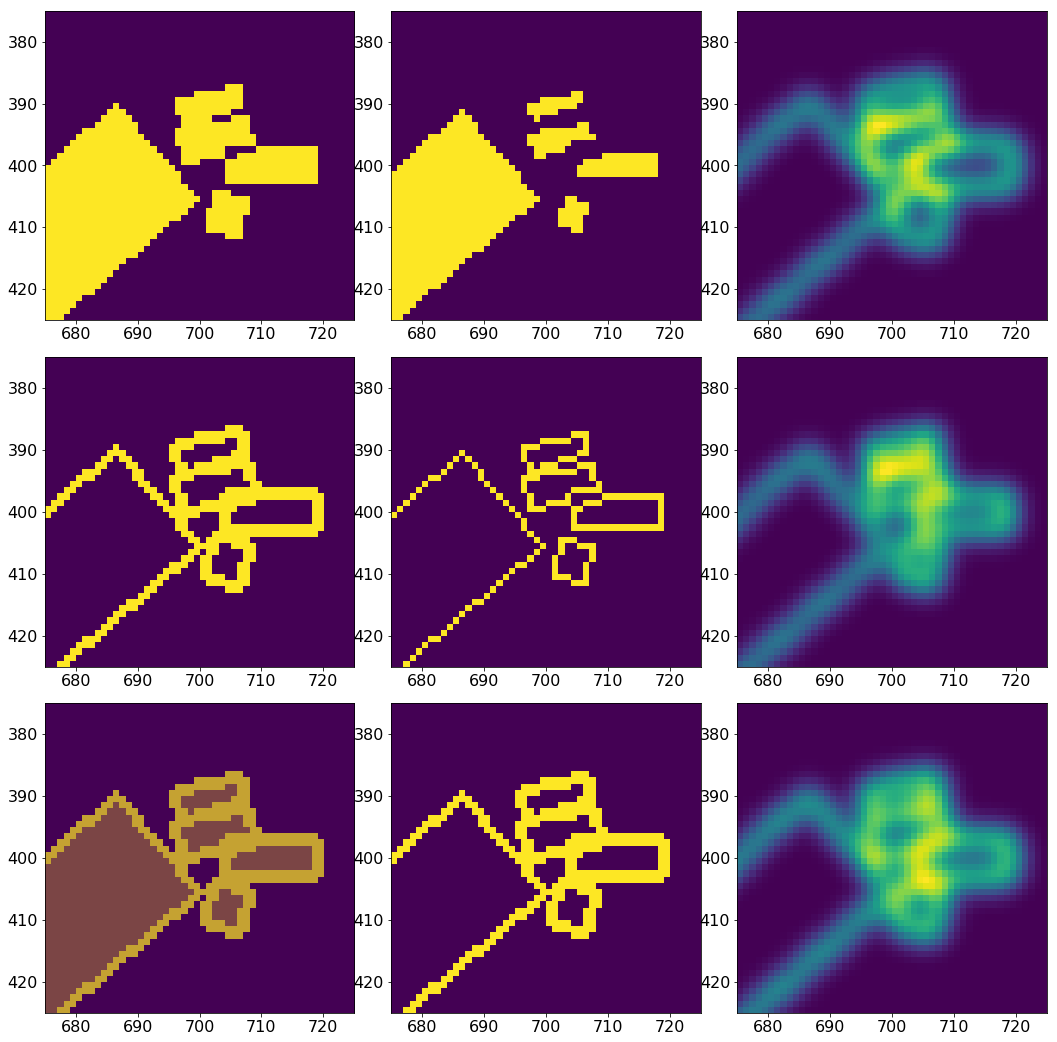

In [163]:
x1, x2 = 675, 725
y1, y2 = 375, 425
c_img = img[y1:y2,x1:x2]
c_msk = msk[y1:y2,x1:x2]
c_msk_in = msk_in[y1:y2,x1:x2]
c_bnd_in = bnd_in[y1:y2,x1:x2]
c_wht_in = wht_in[y1:y2,x1:x2]
c_bnd_out = bnd_out[y1:y2,x1:x2]
c_wht_out = wht_out[y1:y2,x1:x2]
c_bnd = bnd[y1:y2,x1:x2]
c_wht = wht[y1:y2,x1:x2]
c_wht2 = wht2[y1:y2,x1:x2]
fig, axarr = plt.subplots(3, 3, figsize=(15, 15))
axarr[0][0].imshow(c_msk, extent=[x1, x2, y2, y1])
# axarr[0][0].imshow(c_bnd_out, extent=[x1, x2, y2, y1], alpha=0.3)
axarr[0][1].imshow(c_seg2[..., 0], extent=[x1, x2, y2, y1], alpha=0.3)
axarr[0][2].imshow(c_wht_out, extent=[x1, x2, y2, y1])
axarr[1][0].imshow(c_seg1[..., 0], extent=[x1, x2, y2, y1])
# axarr[1][0].imshow(c_img, extent=[x1, x2, y2, y1])
# axarr[1][0].imshow(c_bnd_in, extent=[x1, x2, y2, y1], alpha=0.3)
axarr[1][1].imshow(c_bnd_in, extent=[x1, x2, y2, y1])
axarr[1][2].imshow(c_wht_in, extent=[x1, x2, y2, y1])
# axarr[2][0].imshow(c_wht2, extent=[x1, x2, y2, y1])
axarr[2][0].imshow(c_bnd, extent=[x1, x2, y2, y1])
axarr[2][0].imshow(c_msk_in, extent=[x1, x2, y2, y1], alpha=0.3)
axarr[2][1].imshow(c_bnd, extent=[x1, x2, y2, y1])
axarr[2][2].imshow(c_wht, extent=[x1, x2, y2, y1])
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()
fig.savefig('inout_gaussian.jpg')